##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 確率的主成分分析（PCA）

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Probabilistic_PCA"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Probabilistic_PCA.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Probabilistic_PCA.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/Probabilistic_PCA.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

確率的主成分分析（PCA）は、低次元の潜在空間を介してデータを分析する次元削減手法です（[Tipping and Bishop 1999](#1)）。データの値が欠落している場合や多次元スケーリングに多く使用されます。

## インポート

In [ ]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

## モデル

$N$ データポイントのデータセット $\mathbf{X} = {\mathbf{x}_n}$ を検討します。各データポイントは $D$-dimensional, $\mathbf{x}_n \in \mathbb{R}^D$ です。低次元 $K &lt; D$ で、潜在変数 $\mathbf{z}_n \in \mathbb{R}^K$ で各 $\mathbf{x}_n$ を表現したいと思います。主軸 $\mathbf{W}$ のセットは、潜在変数をデータに関連付けます。

具体的には、各潜在変数は正規に分布されていると仮定します。

$$ \begin{equation*} \mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}). \end{equation*} $$

対応するデータポイントは、プロジェクションを介して生成されます。

$$ \begin{equation*} \mathbf{x}_n \mid \mathbf{z}_n \sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}), \end{equation*} $$

上記の行列 $\mathbf{W}\in\mathbb{R}^{D\times K}$ は主軸として知られています。確率的 PCA では通常、主軸 $\mathbf{W}$ とノイズ項 $\sigma^2$ の推定に関心があります。

確率的 PCA は、古典的な PCA を一般化したものです。潜在変数を除外した場合、各データポイントの分布は、次のようになります。

$$ \begin{equation*} \mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^\top + \sigma^2\mathbf{I}). \end{equation*} $$

古典的な PCA は、ノイズの共分散が $\sigma^2 \to 0$ のように非常に小さくなる確率的 PCA 特有のケースです。

モデルを以下のようにセットアップしました。この分析では、$\sigma$ が既知であると想定しており、$\mathbf{W}$ をモデルパラメータとして想定しているポイントの代わりに、主軸に対する分布を推論するために事前分布をかぶせています。このモデルを TFP JointDistribution として表現し、具体的に、[JointDistributionCoroutineAutoBatched](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionCoroutineAutoBatched) を使用します。

In [ ]:
def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
  w = yield tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=2.0 * tf.ones([data_dim, latent_dim]),
                 name="w")
  z = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z")
  x = yield tfd.Normal(loc=tf.matmul(w, z),
                       scale=stddv_datapoints,
                       name="x")

In [ ]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

concrete_ppca_model = functools.partial(probabilistic_pca,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutineAutoBatched(concrete_ppca_model)

## データ

このモデルを使用し、同時事前分布からサンプリングしてデータを生成することができます。

In [ ]:
actual_w, actual_z, x_train = model.sample()

print("Principal axes:")
print(actual_w)

Principal axes:
tf.Tensor(
[[ 2.2801023]
 [-1.1619819]], shape=(2, 1), dtype=float32)


データセットを視覚化します。

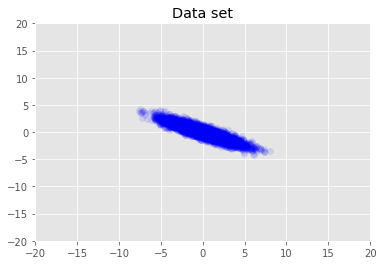

In [ ]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()

## 最大事後確率推定

まず、事後確率密度を最大化する潜在変数の点推定を探します。これは、最大事後確率（MAP）推定法として知られており、事後確率密度 $p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X}) \propto p(\mathbf{W}, \mathbf{Z}, \mathbf{X})$ を最大化する $\mathbf{W}$ と $\mathbf{Z}$ の値を計算することで行われます。


In [ ]:
w = tf.Variable(tf.random.normal([data_dim, latent_dim]))
z = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))

target_log_prob_fn = lambda w, z: model.log_prob((w, z, x_train))
losses = tfp.math.minimize(
    lambda: -target_log_prob_fn(w, z),
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

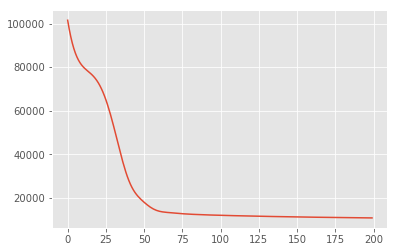

In [ ]:
plt.plot(losses)

モデルを使用して、$\mathbf{W}$ と $\mathbf{Z}$ の推定値を得るデータをサンプリングし、条件を設定した実際のデータセットと比較します。

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.9135954],
       [-1.4826864]], dtype=float32)>


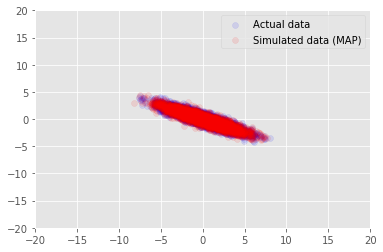

In [ ]:
print("MAP-estimated axes:")
print(w)

_, _, x_generated = model.sample(value=(w, z, None))

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

## 変分推論

MAP は、事後分布のモード（またはモードの 1 つ）を見つけるために使用できますが、それに関するインサイトは何も提供しません。次に、変分推論を使用してみましょう。事後分布 $p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X})$ は $\boldsymbol{\lambda}$ でパラメーター化された変分分布 $q(\mathbf{W}, \mathbf{Z})$ を使用して概算されます。q と事後分布の KL 発散を*最小化*する変分パラメーター $\boldsymbol{\lambda}$ を見つけること（$\mathrm{KL}(q(\mathbf{W}, \mathbf{Z}) \mid\mid p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X}))$）または同様に、根拠の下限を*最大化*する変分パラメーター $\boldsymbol{\lambda}$ を見つけること（$\mathbb{E}_{q(\mathbf{W},\mathbf{Z};\boldsymbol{\lambda})}\left[ \log p(\mathbf{W},\mathbf{Z},\mathbf{X}) - \log q(\mathbf{W},\mathbf{Z}; \boldsymbol{\lambda}) \right]$）を目標とします。


In [ ]:
qw_mean = tf.Variable(tf.random.normal([data_dim, latent_dim]))
qz_mean = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))
qw_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([data_dim, latent_dim]),
                                        bijector=tfb.Softplus())
qz_stddv = tfp.util.TransformedVariable(
    1e-4 * tf.ones([latent_dim, num_datapoints]),
    bijector=tfb.Softplus())
def factored_normal_variational_model():
  qw = yield tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
  qz = yield tfd.Normal(loc=qz_mean, scale=qz_stddv, name="qz")

surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(
    factored_normal_variational_model)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

Inferred axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.4168603],
       [-1.2236133]], dtype=float32)>
Standard Deviation:
<TransformedVariable: dtype=float32, shape=[2, 1], fn="softplus", numpy=
array([[0.0042499 ],
       [0.00598824]], dtype=float32)>


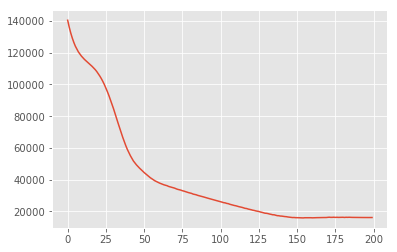

In [ ]:
print("Inferred axes:")
print(qw_mean)
print("Standard Deviation:")
print(qw_stddv)

plt.plot(losses)
plt.show()

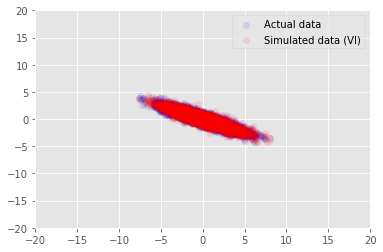

In [ ]:
posterior_samples = surrogate_posterior.sample(50)
_, _, x_generated = model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

## 謝辞

このチュートリアルは Edward 1.0  ([出典](https://github.com/blei-lab/edward/blob/master/notebooks/probabilistic_pca.ipynb)) に掲載されたものです。そのバージョンの作成と改訂に貢献されたすべての人に感謝します。

#### 参照文献

<a name="1"></a>[1]: Michael E. Tipping and Christopher M. Bishop. Probabilistic principal component analysis. *Journal of the Royal Statistical Society: Series B (Statistical Methodology)*, 61(3): 611-622, 1999.